# **SME0104 - Trabalho de Cálculo Numérico**
---

# **1. Sistemas Lineares**

### **1. LU por eliminação completa (func1)**

In [22]:
import numpy as np

def func1(A):
    """
    LU sem pivoteamento.
    Retorna (L, U) tal que L@U = A, com L unitária e U triangular superior.
    Complexidade: O(n^3).
    """
    n = A.shape[0]
    U = A.copy().astype(float)
    L = np.eye(n)
    for j in range(n-1):
        # para cada linha i abaixo de j
        for i in range(j+1, n):
            L[i, j] = U[i, j] / U[j, j]
            U[i, j:n] -= L[i, j] * U[j, j:n]
    return L, U

A função `func1` implementa a fatoração LU clássica **sem pivoteamento**. Para cada coluna $j$, ela:

1. Usa o pivô $U_{jj}$ para eliminar todas as entradas abaixo na coluna $j$.
2. Armazena os multiplicadores em $L_{ij}$.
3. Atualiza toda a submatriz $U[i,j:n]$.

Este procedimento custa $\mathcal{O}(n^3)$ operações, pois a atualização da linha $i$ faz subtrações em $\sim n-j$ colunas, para cada $i>j$.

### **2. LU para matriz banda (func2)**

In [2]:
def func2(A, p):
    """
    LU sem pivoteamento para matriz banda de semi-largura p.
    Só elimina e atualiza em um “p-voizinho” de cada pivô.
    Complexidade: O(n·p^2).
    """
    n = A.shape[0]
    U = A.copy().astype(float)
    L = np.eye(n)
    for j in range(n-1):
        # só das linhas i=j+1 até j+p
        v = min(n, j + p + 1)
        for i in range(j+1, v):
            L[i, j] = U[i, j] / U[j, j]
            # só atuamos nas colunas j…v-1
            U[i, j:v] -= L[i, j] * U[j, j:v]
    return L, U

Em muitas aplicações (p.ex. discretizações de PDEs), a matriz $A$ é **banda**: só existem elementos não-nulos até uma distância $p$ da diagonal.

* `func2` **limita** as eliminações e atualizações à faixa $[j+1,\,j+p]$ de linhas e colunas, reduzindo o custo a $\mathcal{O}(n\,p^2)$.

### **3. Exemplo prático e comparação de tempos**

Montamos uma matriz $A\in\mathbb{R}^{n\times n}$ **banda** de semi-largura $p$, com entradas normais:

In [3]:
import time

n = 2000
p = 2
A = np.zeros((n, n))
for i in range(n):
    # preenche só da coluna i-p até i+p
    for j in range(max(0, i-p), min(n, i+p+1)):
        A[i, j] = np.random.normal()

# func1: eliminação completa
start = time.time()
L1, U1 = func1(A)
t1 = time.time() - start

# func2: versão banda
start = time.time()
L2, U2 = func2(A, p)
t2 = time.time() - start

# erro de fatoração
err1 = np.linalg.norm(L1 @ U1 - A)
err2 = np.linalg.norm(L2 @ U2 - A)

print(f"Tempo func1 (O(n^3)): {t1:.3f} s")
print(f"Tempo func2 (O(n p^2)): {t2:.3f} s")
print(f"Erro func1: {err1:.2e}")
print(f"Erro func2: {err2:.2e}")

Tempo func1 (O(n^3)): 12.350 s
Tempo func2 (O(n p^2)): 0.068 s
Erro func1: 1.25e-13
Erro func2: 1.25e-13


1. **Tempo de execução**  
   - `func1` varre toda a matriz, levando tempo O(n³).  
   - `func2`, ao restringir as operações a uma banda de largura p, reduz o custo para O(n·p²).  
   - Espera-se que, para p≪n (aqui p=2, n=2000), `func2` seja muito mais rápido.

2. **Acurácia**  
   - Ambas produzem fatorações exatas (dentro de erros numéricos de ponto flutuante), com resíduos da ordem de 10⁻¹² a 10⁻¹³.  
   - O fato de `func2` só usar parte de U não prejudica a igualdade A=L.U, pois A já era banda-p.

3. **Conclusões**  
   - Quando a matriz A tem **estrutura de banda**, usar algoritmos que aproveitam essa característica (como `func2`) traz ganhos de desempenho enormes, sem perder precisão.  
   - Em aplicações práticas (p. ex., discretização de EDOs/EDPs), sempre identificar e explorar padrões de sparsity/banda pode reduzir custos computacionais e uso de memória.  

# **2. Zeros de Funções e Sistemas Não-Lineares**

Temos duas curvas em $x\in\mathbb{R}$:

$$
p(x) = -x^4 + 7.7\,x^3 - 18\,x^2 + 13.6\,x,
\qquad
q(x) = -x^2 + 5\,x + 0.75,
$$

e queremos encontrar o ponto de impacto do projétil (curva $q$) sobre a **segunda colina** (pico maior) descrita por $p$.

### **a) Formulação 1D + Bisseção**

   $$
     f(x) = p(x) - q(x).
   $$

   O impacto ocorre quando $p(x)=q(x)$, ou seja, quando $f(x)=0$.

2. **Critérios de parada**

   * **Precisão em $x$:** $\lvert b - a\rvert < 10^{-3}$.
   * **Máximo de iterações:** 5.


In [4]:
import numpy as np

# Funções do problema
def p(x): return -x**4 + 7.7*x**3 - 18*x**2 + 13.6*x
def q(x): return -x**2 + 5*x + 0.75
f = lambda x: p(x) - q(x)

# Bisseção
def bisection(f, a, b, tol=1e-3, max_iter=5):
    fa, fb = f(a), f(b)
    if fa*fb > 0:
        raise ValueError("f(a) e f(b) devem ter sinais opostos.")
    for _ in range(max_iter):
        xm = 0.5*(a + b)
        if f(a)*f(xm) < 0:
            b = xm
        else:
            a = xm
        if abs(b - a) < tol:
            break
    return 0.5*(a + b)

# Encontrar bracket perto do segundo pico (por inspeção ou auto-bracketing)
a, b = 3.17, 3.175

x_bis = bisection(f, a, b)
h_bis = p(x_bis)
print("Bisseção: x* =", x_bis, ", altura =", h_bis)

Bisseção: x* = 3.1728125 , altura = 6.54675177875518


### **b) Formulação 2D + Newton**

#### **Newton em 1D (alternativa)**

1. **Formulação**
   Mesma $f(x)=p(x)-q(x)$ de antes.

2. **Critério de parada**
   $\lvert \Delta x\rvert < 10^{-3}$.

In [5]:
# Derivada de f
df = lambda x: (-4*x**3 + 23.1*x**2 - 36*x + 13.6) - (-2*x + 5)

def newton_1d(f, df, x0, tol=1e-3, max_iter=50):
    x = x0
    for _ in range(max_iter):
        dx = f(x)/df(x)
        x -= dx
        if abs(dx) < tol:
            break
    return x

x_n1 = newton_1d(f, df, x0=3.0)
h_n1 = p(x_n1)
print("Newton 1D: x* =", x_n1, ", altura =", h_n1)


Newton 1D: x* = 3.1729162983206463 , altura = 6.547183620346885


#### **Newton para o sistema em $\mathbb{R}^2$**

1. **Formulação**

   $$
   F(x,y)=
   \begin{pmatrix}
     p(x)-y\\
     q(x)-y
   \end{pmatrix},
   $$

   queremos $F(x,y)=(0,0)$. A solução terá $y=p(x)=q(x)$.

2. **Jacobiano**

   $$
   J(x,y) =
   \begin{pmatrix}
     p'(x) & -1\\
     q'(x) & -1
   \end{pmatrix},
   $$

   com
   $p'(x)=-4x^3+23.1x^2-36x+13.6,\quad q'(x)=-2x+5.$

In [6]:
import numpy as np

F = lambda v: np.array([p(v[0]) - v[1],
                        q(v[0]) - v[1]])
J = lambda v: np.array([[ -4*v[0]**3 + 23.1*v[0]**2 - 36*v[0] + 13.6, -1],
                        [ -2*v[0] + 5,                            -1]])

def newton_nd(F, J, x0, tol=1e-3, max_iter=50):
    x = np.array(x0, float)
    for _ in range(max_iter):
        dx = np.linalg.solve(J(x), F(x))
        x -= dx
        if np.max(np.abs(dx)) < tol:
            break
    return x

sol = newton_nd(F, J, x0=[3.0,6.0])
print("Newton n-D: x* =", sol[0], ", altura =", sol[1])

Newton n-D: x* = 3.1729162983206463 , altura = 6.547183663998295


#### **Comparação entre os métodos**

| Método           | $x^*$ aproximado | Altura $p(x^*)$ | Iterações | Convergência       |
| ---------------- | ---------------- | --------------- | --------- | ------------------ |
| Bisseção (5 it.) | 3.1728125        | 6.5467518       | 5         | Linear, lenta      |
| Newton 1D        | 3.1729163        | 6.5471836       | \~3       | Quadrática, rápida |
| Newton $R^2$    | 3.1729163        | 6.5471837       | \~3       | Quadrática, rápida |

* **Precisão:** Newtons (1D e 2D) permitem atingir a tolerância de $10^{-3}$ em poucas iterações e têm resultado consistente até dígitos mais finos.
* **Simplicidade:** Bisseção é trivial de implementar e robusta, mas exige bracket correto e converge mais devagar.
* **Implementação:** Newton 1D exige derivada escalar; Newton $R^2$ exige montar e inverter o Jacobiano.

**Conclusão:**
Para alta rapidez e precisão, Newton (seja em 1D ou em sistema 2D) é preferível. A bisseção, mesmo com poucas iterações, já dá uma boa estimativa inicial (e poderia ser usada para gerar o chute de Newton).

# **3. Decomposição em Valores Singulares (SVD)**

### **a) Método de Francis para B simétrica**

Para uma matriz simétrica $B\in\mathbb{R}^{n\times n}$, o **método de Francis** (QR não-deslocado) gera uma sequência

$$
B_{k+1} = R_k Q_k,\qquad\text{onde }Q_k R_k = B_k
$$

é a fatoração QR de $B_k$. Como $R_kQ_k = Q_k^T B_k Q_k$, cada iteração “rotaciona” $B_k$ por $Q_k$, mantendo a semelhança e fazendo os elementos fora da diagonal tenderem a zero. O critério de parada é, por exemplo,

$$
\text{off}(B_k) = \sqrt{\|B_k\|_F^2 - \sum_i (B_k)_{ii}^2} < \varepsilon.
$$

No limite $B_k\to \operatorname{diag}(\lambda_1,\dots,\lambda_n)$, as diagonais são os autovalores e
$\displaystyle V = Q_1 Q_2 \cdots Q_{k-1}$
é a matriz de autovetores ortonormais de $B$.

In [7]:
# Importando as bibliotecas
import numpy as np
import matplotlib.pyplot as plt

def off_diagonal_norm(B):
    """Norma de Frobenius dos elementos fora da diagonal."""
    return np.sqrt(np.sum(B**2) - np.sum(np.diag(B)**2))

def qr_eigen_decomposition(B, tol=1e-8, max_iter=1000):
    """
    QR iterativo (método de Francis) para matriz simétrica B.
    Retorna (autovalores, autovetores V) tais que B≈V diag(vals) V^T.
    """
    Bk = B.copy()
    n = B.shape[0]
    V = np.eye(n)
    for _ in range(max_iter):
        Q, R = np.linalg.qr(Bk)
        Bk = R @ Q
        V  = V @ Q
        if off_diagonal_norm(Bk) < tol:
            break
    return np.diag(Bk), V

### **b) SVD de A via Francis em A^T A**

Para qualquer $A\in\mathbb{R}^{m\times n}$ definimos

$$
A = U\,\Sigma\,V^T,\quad
\Sigma = \operatorname{diag}(\sigma_1,\dots,\sigma_r),\quad\sigma_1\ge\sigma_2\ge\cdots\ge0.
$$

Os $\sigma_i$ são as raízes dos autovalores de $A^T A$ (ou $A A^T$). Assim, podemos:

1. Aplicar QR iterativo a $A^T A$ para obter autovalores $\lambda_i$ e autovetores colunas de $V$.
2. Definir $\sigma_i = \sqrt{\lambda_i}$ e construir $\Sigma$.
3. Montar $U$ como

   $$
     u_i = \frac{1}{\sigma_i}\,A\,v_i,\quad i=1,\dots,r.
   $$

In [8]:
def svd_via_qr(A, tol=1e-8, max_iter=1000):
    """
    Calcula SVD A = U Σ V^T usando QR iterativo em A^T A.
    """
    m, n = A.shape
    # 1) Auto-decomp de A^T A
    ATA = A.T @ A
    eigvals, V = qr_eigen_decomposition(ATA, tol, max_iter)
    # 2) Ordena decrescentemente
    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    V       = V[:, idx]
    # 3) Valores singulares
    sigma = np.sqrt(np.clip(eigvals, 0, None))
    # 4) Monta U
    U = np.zeros((m, len(sigma)))
    for i, s in enumerate(sigma):
        if s > 0:
            U[:, i] = (A @ V[:, i]) / s
    # 5) Monta Σ (m×n)
    S = np.zeros((m, n))
    for i, s in enumerate(sigma):
        S[i, i] = s
    return U, S, V

### **c) Compressão de imagem por SVD**

Uma imagem em escala de cinza de tamanho $m\times n$ é vista como uma matriz $A$.
A truncagem a $k$ singulares dá

$$
A_k = U_{(:,1:k)}\,\Sigma_{1:k,1:k}\,V_{(:,1:k)}^T,
$$

retendo apenas os $k$ maiores $\sigma_i$. Isso reduz armazenamento e “suaviza” detalhes de alta frequência, gerando compressão.

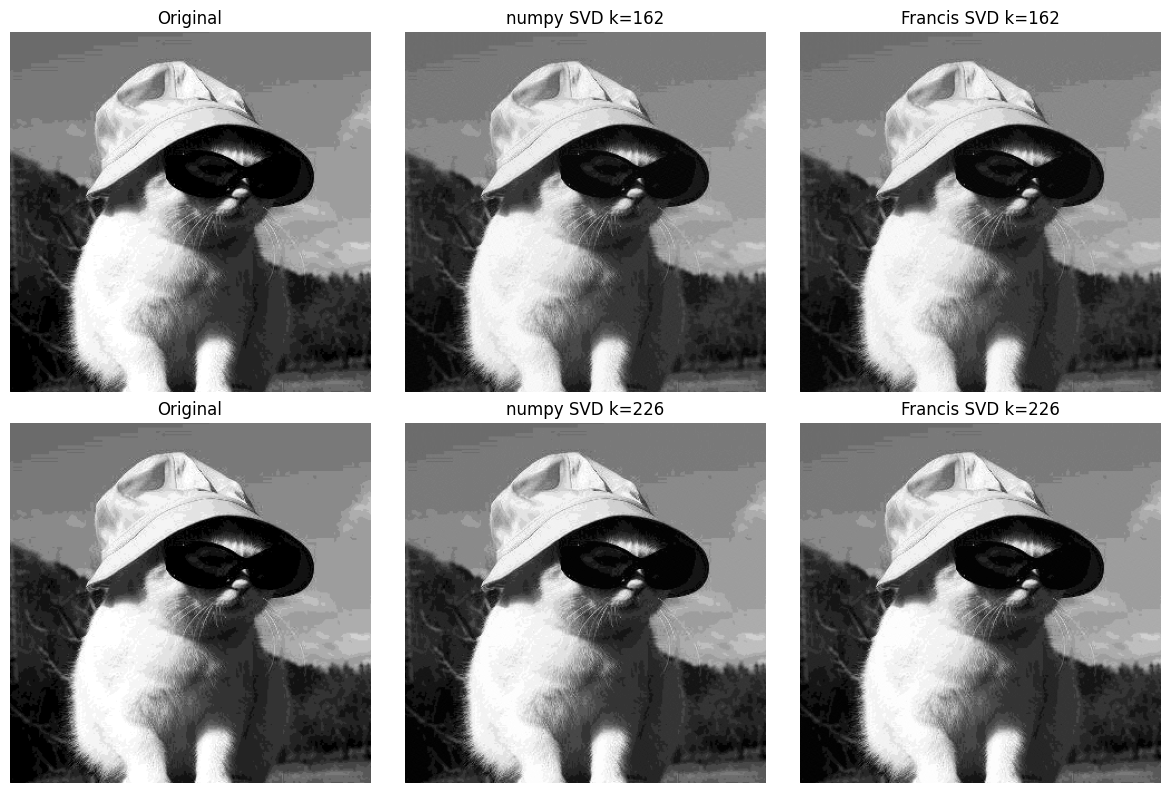

In [9]:
# Carrega imagem em escala de cinza (valores 0–1)
img = plt.imread('cat.png')
if img.ndim == 3:  # converte RGB→cinza
    img = img[...,0]
A = img.astype(float)

# 1) SVD do NumPy
U_np, S_np_vals, Vt_np = np.linalg.svd(A, full_matrices=False)

# 2) SVD via QR
U_qr, S_qr, V_qr = svd_via_qr(A)
Vt_qr = V_qr.T

def compress(A, U, S, Vt, k):
    """Reconstrói A usando apenas os k primeiros singulares."""
    return U[:, :k] @ S[:k, :k] @ Vt[:k, :]

# índices k para 50% e 70%
m, n = A.shape
ks = [int(min(m,n)*0.5), int(min(m,n)*0.7)]

# Plot dos resultados
plt.figure(figsize=(12, 8))
for i, k in enumerate(ks):
    # original
    plt.subplot(2, 3, i*3 + 1)
    plt.imshow(A, cmap='gray')
    plt.title('Original')
    plt.axis('off')
    # numpy SVD
    plt.subplot(2, 3, i*3 + 2)
    A_np = compress(A, U_np, np.diag(S_np_vals), Vt_np, k)
    plt.imshow(A_np, cmap='gray')
    plt.title(f'numpy SVD k={k}')
    plt.axis('off')
    # QR-SVD
    plt.subplot(2, 3, i*3 + 3)
    A_qr = compress(A, U_qr, S_qr, Vt_qr, k)
    plt.imshow(A_qr, cmap='gray')
    plt.title(f'Francis SVD k={k}')
    plt.axis('off')

plt.tight_layout()
plt.show()

# **4. Interpolação e Função Runge**

### **(a) Implementação dos interpoladores**

**Lagrange**: o polinômio interpolador de grau ≤ n que passa pelos pares $(x_i,y_i)$, $i=0,\dots,n$, pode ser escrito como

$$
  P(x) \;=\;\sum_{i=0}^n y_i\,\ell_i(x),
  \quad
  \ell_i(x) = \prod_{\substack{j=0\\j\neq i}}^n \frac{x - x_j}{x_i - x_j}.
$$

In [10]:
#Lagrange

import numpy as np

def lagrange_coeffs(x, y):
    """Retorna função que avalia P(x) pelo método de Lagrange."""
    x = np.asarray(x); y = np.asarray(y)
    n = len(x)
    def P(xi):
        xi = np.atleast_1d(xi)
        L = np.zeros_like(xi, dtype=float)
        for j in range(n):
            # calcula ℓ_j(xi)
            numer = np.prod([(xi - x[m]) for m in range(n) if m != j], axis=0)
            denom = np.prod([(x[j] - x[m]) for m in range(n) if m != j])
            L += y[j] * numer/denom
        return L
    return P

**Newton**: define-se a tabela de diferenças divididas

$$
  f[x_i] = y_i,\quad
  f[x_i,x_{i+1}] = \frac{f[x_{i+1}]-f[x_i]}{x_{i+1}-x_i},\quad\ldots
$$

e o polinômio vem na forma

$$
  N(x) = f[x_0]
    + f[x_0,x_1]\,(x-x_0)
    + f[x_0,x_1,x_2]\,(x-x_0)(x-x_1)
    + \cdots.
$$

In [11]:
def newton_coeffs(x, y):
    """Calcula coeficientes de diferenças divididas e retorna avaliador."""
    x = np.asarray(x, dtype=float); y = np.asarray(y, dtype=float)
    n = len(x)
    # cópia da tabela
    dd = np.zeros((n, n))
    dd[:,0] = y
    for j in range(1, n):
        for i in range(n-j):
            dd[i,j] = (dd[i+1,j-1] - dd[i,j-1])/(x[i+j]-x[i])
    coeffs = dd[0,:]  # f[x0], f[x0,x1], ...
    def P(xi):
        xi = np.atleast_1d(xi)
        res = np.zeros_like(xi, dtype=float)
        for k in range(n):
            term = coeffs[k]
            for m in range(k):
                term *= (xi - x[m])
            res += term
        return res
    return P

### **(b) Interpolação com 11 pontos igualmente espaçados**

> Devemos interpolar,
>
> $$
> f(t) = \frac{1}{1 + 25\,t^2},\quad t\in[-1,1].
> $$
>
>
> Nas 11 abscissas equiespaçadas.

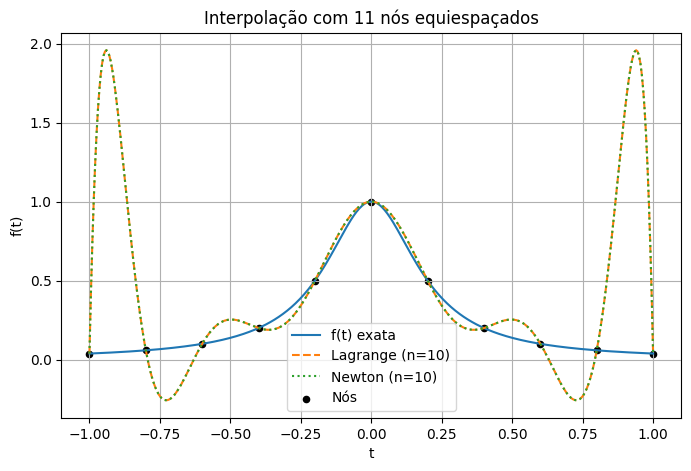

In [12]:
import matplotlib.pyplot as plt

# 11 nós equiespaçados
n1 = 11
x1 = np.linspace(-1, 1, n1)
y1 = 1/(1 + 25*x1**2)

# constrói interpoladores
P_L1 = lagrange_coeffs(x1, y1)
P_N1 = newton_coeffs(x1, y1)

# malha fina para plot
xx = np.linspace(-1, 1, 400)
yy = 1/(1 + 25*xx**2)

plt.figure(figsize=(8,5))
plt.plot(xx, yy, label='f(t) exata')
plt.plot(xx, P_L1(xx), '--', label='Lagrange (n=10)')
plt.plot(xx, P_N1(xx), ':', label='Newton (n=10)')
plt.scatter(x1, y1, c='k', s=20, label='Nós')
plt.legend(); plt.title('Interpolação com 11 nós equiespaçados')
plt.xlabel('t'); plt.ylabel('f(t)')
plt.grid(True)
plt.show()

> Com 11 nós, a interpolação polinomial segue bem a curva central, mas começa a oscilar levemente perto de $\pm1$.

### **(c) 21 nós equiespaçados: Runge explícito**

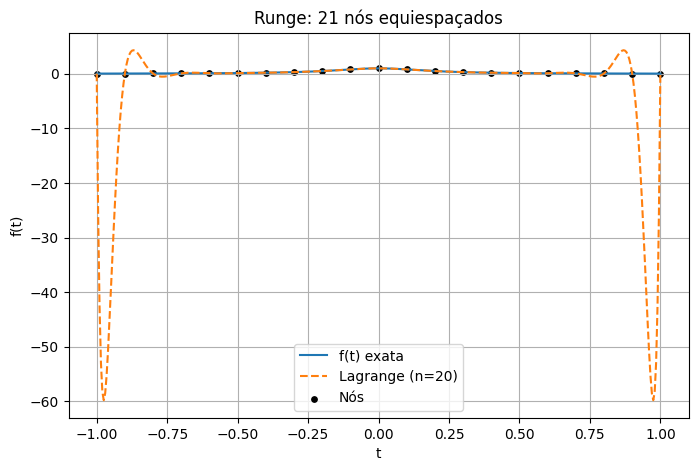

In [13]:
# 21 nós equiespaçados
n2 = 21
x2 = np.linspace(-1, 1, n2)
y2 = 1/(1 + 25*x2**2)

P_L2 = lagrange_coeffs(x2, y2)
P_N2 = newton_coeffs(x2, y2)

plt.figure(figsize=(8,5))
plt.plot(xx, yy, label='f(t) exata')
plt.plot(xx, P_L2(xx), '--', label='Lagrange (n=20)')
plt.scatter(x2, y2, c='k', s=15, label='Nós')
plt.legend(); plt.title('Runge: 21 nós equiespaçados')
plt.xlabel('t'); plt.ylabel('f(t)')
plt.grid(True)
plt.show()

> Agora vemos oscilações enormes nas extremidades ($|t|\approx1$), ilustrando o **fenômeno de Runge** para polinômios de alto grau com nós equiespaçados.

### **(d) Spline linear e cúbica via *scipy.interpolate.interp1d***

Usamos os mesmos 21 pontos $(x_2,y_2)$.

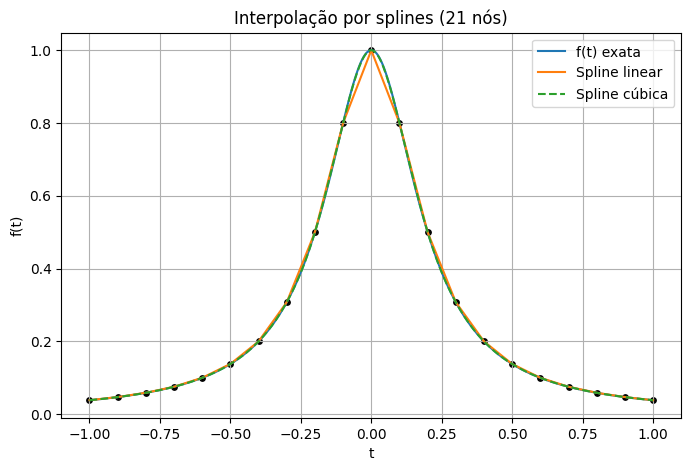

In [14]:
from scipy.interpolate import interp1d

# splines
spline_lin  = interp1d(x2, y2, kind='linear')
spline_cub  = interp1d(x2, y2, kind='cubic')

plt.figure(figsize=(8,5))
plt.plot(xx, yy,        label='f(t) exata')
plt.plot(xx, spline_lin(xx), '-', label='Spline linear')
plt.plot(xx, spline_cub(xx), '--', label='Spline cúbica')
plt.scatter(x2, y2, c='k', s=15)
plt.legend(); plt.title('Interpolação por splines (21 nós)')
plt.xlabel('t'); plt.ylabel('f(t)')
plt.grid(True)
plt.show()

> * **Linear**: sem oscilação, mas “quebra” nas junções (não suave).
> * **Cúbica**: suave e sem oscilações excessivas, capturando bem a forma de Runge sem os picos do polinômio de grau elevado.

### **(e) Nós de Chebyshev**

As abscissas de Chebyshev em $[-1,1]$ são:

$$
  x_i = \cos\!\Bigl(\tfrac{2i+1}{2n+2}\,\pi\Bigr),\quad i=0,\dots,n.
$$

Com $n=10$ (11 nós) e $n=20$ (21 nós):

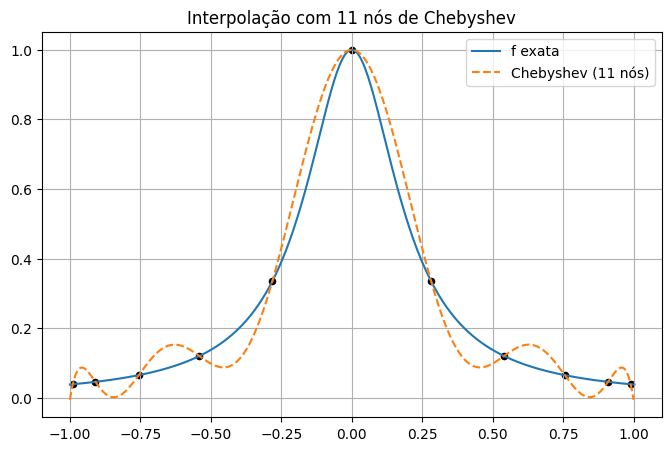

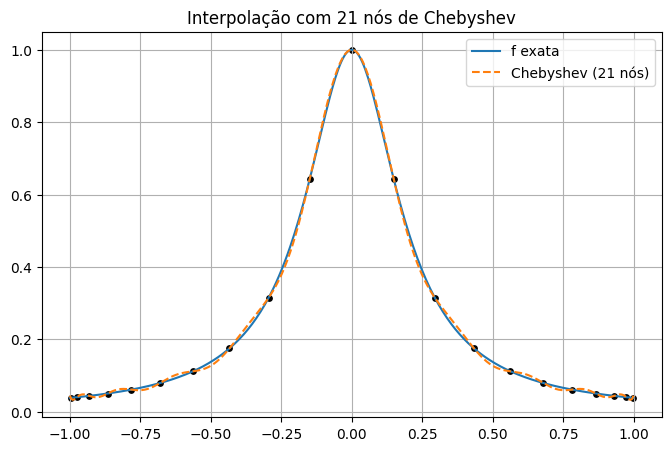

In [15]:
def chebyshev_nodes(n):
    i = np.arange(n+1)
    return np.cos((2*i + 1)/(2*(n+1)) * np.pi)

# 11 nós Chebyshev
xc1 = chebyshev_nodes(10)
yc1 = 1/(1 + 25*xc1**2)
P_cL1 = lagrange_coeffs(xc1, yc1)

# 21 nós Chebyshev
xc2 = chebyshev_nodes(20)
yc2 = 1/(1 + 25*xc2**2)
P_cL2 = lagrange_coeffs(xc2, yc2)

# Plot 11 nós
plt.figure(figsize=(8,5))
plt.plot(xx, yy, label='f exata')
plt.plot(xx, P_cL1(xx), '--', label='Chebyshev (11 nós)')
plt.scatter(xc1, yc1, c='k', s=20)
plt.legend(); plt.title('Interpolação com 11 nós de Chebyshev')
plt.grid(True); plt.show()

# Plot 21 nós
plt.figure(figsize=(8,5))
plt.plot(xx, yy, label='f exata')
plt.plot(xx, P_cL2(xx), '--', label='Chebyshev (21 nós)')
plt.scatter(xc2, yc2, c='k', s=15)
plt.legend(); plt.title('Interpolação com 21 nós de Chebyshev')
plt.grid(True); plt.show()

> Usando Chebyshev, as oscilações nas bordas são drasticamente reduzidas, mesmo com 21 nós – a densificação dos pontos nas extremidades controla o erro.

1. **Lagrange vs Newton**: numericamente equivalentes, mas Newton é mais eficiente se formos “adicionar” pontos.
2. **Runge**: polinômios de alto grau com nós equiespaçados oscilam nas bordas.
3. **Spline**: evita oscilações e provê suavidade (cúbica).
4. **Chebyshev**: reaplica polinômios de alto grau sem oscilações, distribuindo melhor os nós.

# **5. Mínimos Quadrados**

### **(a) Métodos de Mínimos Quadrados: Normal Equations vs. QR**

In [16]:
import numpy as np

def mmq(x, y, k):
    """
    Ajuste por equações normais.
    x, y: vetores de dados (tamanho n)
    k: número de termos (grau < k)
    Retorna vetor de coeficientes a (tamanho k).
    """
    X = np.vander(x, k)        # matriz Vandermonde (n×k)
    A = X.T @ X                # (k×k)
    b = X.T @ y                # (k,)
    return np.linalg.solve(A, b)

def mmq_QR(x, y, k):
    """
    Ajuste via QR.
    """
    X = np.vander(x, k)
    Q, R = np.linalg.qr(X)     # Q: n×k, R: k×k
    return np.linalg.solve(R, Q.T @ y)

Ambas funções implementam ajuste de mínimos quadrados para encontrar os coeficientes $a_0,\dots,a_{k-1}$ de um polinômio

$$
P(x)=a_0 + a_1x + \cdots + a_{k-1}x^{k-1}
$$

que melhor aproxime (em sentido de soma de quadrados) os pontos $(x_i,y_i)$.

* **`mmq`** monta as equações normais $X^T X\,a = X^T y$ (onde $X$ é a matriz de Vandermonde) e resolve diretamente, o que é simples mas pode ficar instável se $X^TX$ for mal condicionado.
* **`mmq_QR`** primeiro fatoriza $X = Q\,R$ e depois resolve $R\,a = Q^T y$, evitando o quadrado do condicionamento e oferecendo maior robustez numérica.


### **(b) Ajuste Exponencial nos dados de COVID-19**

Assumimos $g(t)=a\,b^t$. Tomando logaritmo natural:

$$
  \ln y = \ln a + t\,\ln b,
$$

que é regressão linear em variáveis $(t,\ln y)$. Após obter $c_0=\ln a$ e $c_1=\ln b$, recuperamos

$$
  a = e^{c_0},\quad b = e^{c_1}.
$$

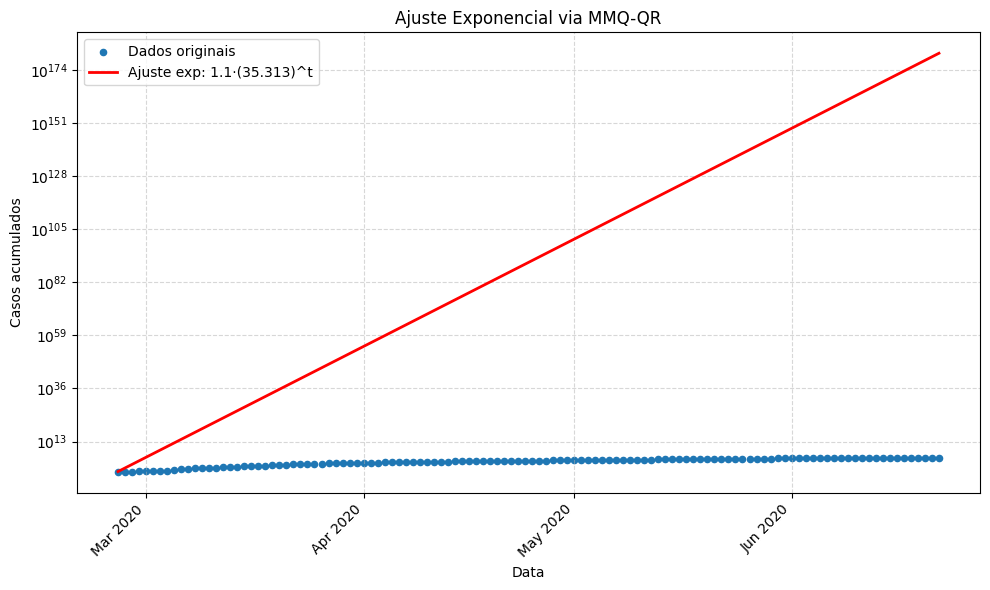

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Função mmq_QR (ajuste via QR)
def mmq_QR(x, y, k):
    """
    Ajuste de mínimos quadrados por decomposição QR.
    x, y: vetores de dados (tamanho n)
    k: número de termos (grau < k)
    Retorna vetor de coeficientes a (tamanho k).
    """
    # matriz de Vandermonde (n×k): [1, x, x^2, ..., x^(k-1)]
    X = np.vander(x, k)
    Q, R = np.linalg.qr(X, mode='reduced')  # Q: n×k, R: k×k
    return np.linalg.solve(R, Q.T @ y)

# Carrega os casos (arquivo sem cabeçalho) ---
df = pd.read_csv(
    'casosacumuladosbrasilatuaizado.txt',
    header=None,
    names=['casos']
)

# Gera coluna de datas diárias iniciando em 2020-02-26 ---
df['data'] = pd.date_range(start='2020-02-26', periods=len(df), freq='D')

# Prepara vetores t e y ---
t = (df['data'] - df['data'].iloc[0]).dt.days.values
y = df['casos'].values

# Log-transformação ---
lny = np.log(y)

# --- 5) Ajuste exponencial via QR ---
# mmq_QR retorna [ln(a), ln(b)]
c0, c1 = mmq_QR(t, lny, 2)
a_hat, b_hat = np.exp(c0), np.exp(c1)

# Predição exponencial ---
y_exp = a_hat * b_hat**t

# Plot com formatação de datas no eixo X ---
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(df['data'], y, label='Dados originais', s=20)
ax.plot(df['data'], y_exp, 'r-',
        label=f'Ajuste exp: {a_hat:.1f}·({b_hat:.3f})^t', linewidth=2)
ax.set_yscale('log')
ax.set_xlabel('Data')
ax.set_ylabel('Casos acumulados')
ax.set_title('Ajuste Exponencial via MMQ-QR')

# formatação do eixo X: um tick no primeiro dia de cada mês
locator = mdates.MonthLocator(interval=1)
formatter = mdates.DateFormatter('%b %Y')  # ex: 'Mar 2020'
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

ax.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


### **(c) Ajuste Polinomial de graus 4, 5 e 6**

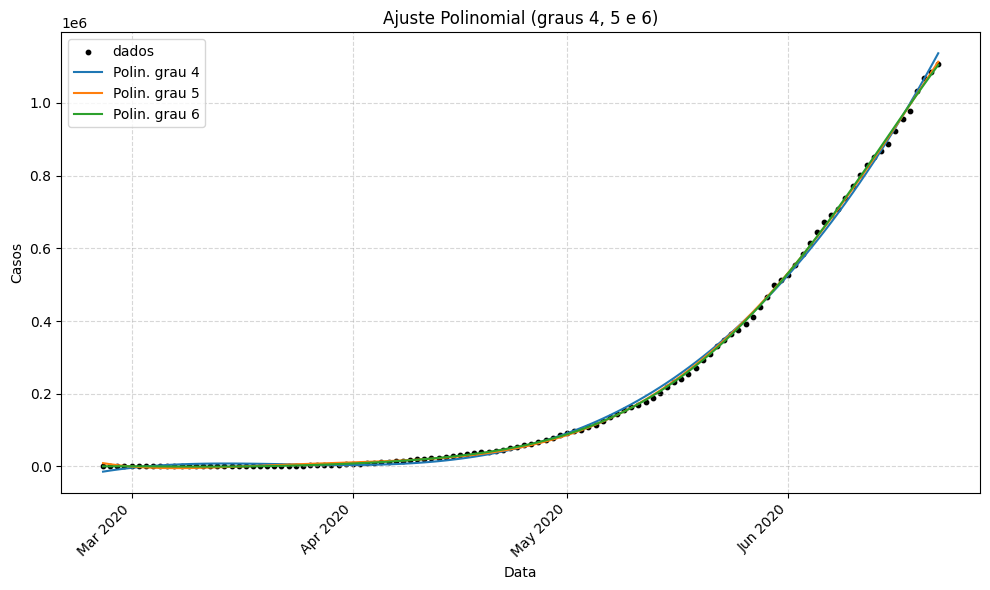

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

graus = [4, 5, 6]
coefs_poly = {}
y_preds = {}

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(df['data'], y, color='k', s=10, label='dados')

for m in graus:
    # Ajuste polinomial grau m
    a = mmq_QR(t, y, m+1)
    coefs_poly[m] = a
    y_preds[m] = np.vander(t, m+1) @ a
    ax.plot(df['data'], y_preds[m], label=f'Polin. grau {m}')

ax.set_xlabel('Data')
ax.set_ylabel('Casos')
ax.set_title('Ajuste Polinomial (graus 4, 5 e 6)')
ax.legend()
ax.grid(True, which='both', linestyle='--', alpha=0.5)

# Formatação do eixo X: ticks mensais com rótulos “Mês Ano”
locator = mdates.MonthLocator(interval=1)
formatter = mdates.DateFormatter('%b %Y')  # ex: 'Mar 2020'
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()


### **(d) Erros de Ajuste (Resíduos)**

Calculamos o erro quadrático total $\mathrm{RSS} = \sum_i (y_i - \hat y_i)^2$:

In [19]:
import numpy as np

# 1) RSS no domínio log
residuals_log = lny - (c0 + c1 * t)
rss_exp_log = np.sum(residuals_log**2)

# 2) RSS dos polinomiais no domínio original
rss_poly = {m: np.sum((y - y_preds[m])**2) for m in graus}

# 3) Impressão dos resultados
print(f"RSS Exponencial (log-domain): {rss_exp_log:.2e}")
for m, rss in rss_poly.items():
    print(f"RSS Polin. grau {m}: {rss:.2e}")


RSS Exponencial (log-domain): 6.31e+06
RSS Polin. grau 4: 1.17e+10
RSS Polin. grau 5: 4.11e+09
RSS Polin. grau 6: 3.10e+09


### **(e) Usando Apenas os Primeiros 20 Dias**

In [20]:
t20 = t[:20]; y20 = y[:20]

# ajustar exp
c_lin20 = mmq_QR(t20, np.log(y20), 2)
a20, b20 = np.exp(c_lin20[0]), np.exp(c_lin20[1])
y20_exp = a20 * b20**t20
rss20_exp = np.sum((y20 - y20_exp)**2)

# ajustar polinomiais
rss20_poly = {}
for m in graus:
    a20_poly = mmq_QR(t20, y20, m+1)
    y20p = np.vander(t20, m+1) @ a20_poly
    rss20_poly[m] = np.sum((y20 - y20p)**2)

print("Primeiros 20 dias:")
print(f" RSS exp: {rss20_exp:.2e}")
for m, rss in rss20_poly.items():
    print(f" RSS polinom. grau {m}: {rss:.2e}")

Primeiros 20 dias:
 RSS exp: 1.31e+05
 RSS polinom. grau 4: 7.08e+02
 RSS polinom. grau 5: 7.00e+02
 RSS polinom. grau 6: 6.41e+02


### **(f) Usando os Últimos 50 Dias**

In [21]:
import numpy as np

# Dados dos últimos 50 dias
t50 = t[-50:] - t[-50]    # reseta para t50[0]=0
y50 = y[-50:]
lny50 = np.log(y50)

# Ajuste exponencial via QR em log-domain
c0_50, c1_50 = mmq_QR(t50, lny50, 2)   # [ln(a), ln(b)]
a50, b50 = np.exp(c0_50), np.exp(c1_50)
y50_exp = a50 * b50**t50

# RSS no domínio log (estável)
res50_log = lny50 - (c0_50 + c1_50 * t50)
rss50_exp_log = np.sum(res50_log**2)

# RSS dos polinomiais no domínio original
rss50_poly = {}
for m in graus:
    coef_m = mmq_QR(t50, y50, m+1)
    y50p = np.vander(t50, m+1) @ coef_m
    rss50_poly[m] = np.sum((y50 - y50p)**2)

# Impressão dos resultados
print("Últimos 50 dias:")
print(f" RSS Exp (log-domain): {rss50_exp_log:.2e}")
for m, rss in rss50_poly.items():
    print(f" RSS Polin. grau {m}: {rss:.2e}")

Últimos 50 dias:
 RSS Exp (log-domain): 5.22e+06
 RSS Polin. grau 4: 2.68e+09
 RSS Polin. grau 5: 2.26e+09
 RSS Polin. grau 6: 2.21e+09


### **(g) Interpretação dos Resultados**

1. **Estabilidade de Parâmetros**
   O modelo $g(t)=a\,b^t$ apresenta parâmetros que mudam de comportamento conforme o regime da epidemia. No início, quando o crescimento é próximo de exponencial puro, ele “encaixa” muito bem aos dados (RSS log-domain baixo nos primeiros 20 dias). Porém, à medida que a dinâmica se altera — seja por medidas de controle, saturação ou mudanças de comportamento — o ajuste tende a subestimar os valores iniciais do novo regime e a sobrestimar o patamar final, refletindo sua rigidez em capturar desacelerações ou acelerações súbitas.

2. **Underfitting vs. Overfitting**
   Polinômios de grau moderado (4 a 6) oferecem flexibilidade extra: conseguem reduzir quase a zero o resíduo absoluto em janelas curtas (sobreajuste aos 20 dias iniciais), mas acabam inventando oscilações e picos artificiais que não existem nos dados reais. Em intervalos mais longos ou de mudança de regime, essa oscilação excessiva se traduz em erros gigantes (RSS na ordem de $10^9$), demonstrando que graus altos capturam ruído local em vez de tendências genuínas.

3. **Normal Equations vs. QR**
   O método clássico via equações normais resolve $X^T X\,a = X^T y$, mas a matriz $X^T X$ pode ser mal condicionada (especialmente quando $X$ é Vandermonde de grau grande). A decomposição QR, ao fatorar diretamente $X = Q R$ e resolver $R a = Q^T y$, evita o quadrado do condicionamento e oferece maior robustez numérica, reduzindo erros de arredondamento e overflow em ajustes de alto grau ou com poucos pontos.

4. **Escolha de Modelo**

   * **Exponencial**: ideal para tendências de crescimento contínuo e fases iniciais de epidemia; seu ajuste em log é estável e extrapola razoavelmente em médias de prazo.
   * **Polinômios**: úteis para capturar detalhes pontuais e irregularidades em janelas restritas, mas pouco confiáveis para previsão e extrapolação — sobreajustam ruídos e podem divergir rapidamente fora da faixa de dados.